In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from scipy.optimize import minimize

/data/khang/anaconda3/envs/torch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Parameters

In [2]:
seed = 1
folds = 5
num_feat = 16
epoch = 10000
# lr = 0.5
alpha = 0.5
mode = 'func'
num_draw = 100

In [3]:
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## 2. Utils

In [4]:
def fold_separation(train_df, folds, feat_cols, label):
    skf = StratifiedKFold(n_splits=folds)
    train_df['fold'] = np.zeros(train_df.shape[0])
    for i, (idxT, idxV) in enumerate(skf.split(train_df[feat_cols], train_df[label])):
        train_df.at[idxV, 'fold'] = i

## 3. Read Data

In [5]:
df = pd.read_csv('Data/Bank/formated_bank.csv')
# df['bias'] = np.ones(df.shape[0])
feature_cols = list(df.columns)
feature_cols.remove('y')
feature_cols.remove('z')
feature_cols.remove('label')
feature_cols.remove('is_train')
feature_cols.remove('intercept')
label = 'y'
train_df = df[df['is_train'] == 1].reset_index(drop=True).sample(frac = 1)
test_df = df[df['is_train'] == 0].reset_index(drop=True).sample(frac = 1)
male_df = train_df[train_df['z'] == 1].copy().reset_index(drop=True)
female_df = train_df[train_df['z'] == 0].copy().reset_index(drop=True)
fold_separation(male_df, folds, feature_cols, label)
fold_separation(female_df, folds, feature_cols, label)
train_df = pd.concat([male_df, female_df], axis=0).reset_index(drop=True)

In [6]:
male_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,z,label,intercept,y,is_train,fold
0,73,2.078277,0.171004,-1.442665,0.13576,0.307118,1.052817,0.434409,0.408136,1.674430,...,-0.236331,-0.476830,-0.371080,-0.470990,1,1,0.0,1,1,0.0
1,84,2.078277,-0.795053,-0.420689,0.13576,26.329134,1.052817,0.434409,0.408136,1.435485,...,-0.545439,2.712669,0.562012,0.489414,1,1,0.0,1,1,0.0
2,61,2.078277,-0.795053,-0.420689,0.13576,-0.424768,1.052817,0.434409,0.681550,1.435485,...,-0.545439,1.371861,0.562012,0.091106,1,0,0.0,0,1,0.0
3,82,2.078277,-0.795053,-0.420689,0.13576,-0.363090,1.052817,0.434409,0.408136,0.121292,...,-0.545439,-0.476830,-0.371080,-0.470990,1,1,0.0,1,1,0.0
4,71,-0.097838,-0.795053,1.371580,0.13576,-0.327798,1.052817,0.434409,0.681550,1.316013,...,0.072777,-0.476830,-0.371080,-0.470990,1,1,0.0,1,1,0.0


## 4. Normal Logistic Regression (Sklearn)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
clf = LogisticRegression(random_state=0, max_iter=epoch, fit_intercept=False, verbose=1).fit(X=male_df[feature_cols].values, y=male_df[label].values)
clf.score(X=male_df[feature_cols].values, y=male_df[label].values)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89229D+02    |proj g|=  4.93350D+03

At iterate   50    f=  1.33082D+02    |proj g|=  3.00376D+01

At iterate  100    f=  1.32380D+02    |proj g|=  8.73875D+00

At iterate  150    f=  1.32333D+02    |proj g|=  2.28232D-01



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


0.7838827838827839

At iterate  200    f=  1.32329D+02    |proj g|=  6.50158D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    202    245      1     0     0   2.393D-02   1.323D+02
  F =   132.32947245790203     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [8]:
y_pred = clf.predict_proba(X=male_df[feature_cols].values)[:,1]
log_loss(y_true=male_df[label], y_pred=y_pred)

0.46990103567364944

In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=epoch, fit_intercept=False).fit(X=female_df[feature_cols].values, y=female_df[label].values)
clf.score(X=female_df[feature_cols].values, y=female_df[label].values)

0.9362363919129082

In [10]:
y_pred = clf.predict_proba(X=female_df[feature_cols].values)[:,1]
log_loss(y_true=female_df[label], y_pred=y_pred)

0.23368934709625303

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=epoch, fit_intercept=False).fit(X=train_df[feature_cols].values, y=train_df[label].values)
clf.score(X=train_df[feature_cols].values, y=train_df[label].values)

0.9189058339385137

## 5. Logistic Regression with Taylor approximation

In [12]:
feature_cols

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome']

### 5.1 With pytorch

In [13]:
# female
X_fem = female_df[feature_cols].values
y_fem = female_df[label].values.reshape(-1, 1)
X_fem = X_fem/np.linalg.norm(X_fem, ord=2, axis=1).reshape(-1, 1)

# male
X_mal = male_df[feature_cols].values
y_mal = male_df[label].values.reshape(-1, 1)
X_mal = X_mal/np.linalg.norm(X_mal, ord=2, axis=1).reshape(-1, 1)

# train
X = train_df[feature_cols].values
y = train_df[label].values.reshape(-1, 1)
X = X/np.linalg.norm(X, ord=2, axis=1).reshape(-1, 1)

In [14]:
def get_coefficient(X, y, epsilon=None, lbda=None, mode='torch'):
    num_data_point = X.shape[0]
    num_feat = X.shape[1]
    sensitivity = num_feat**2/4 + 3*num_feat
#     lbda = sensitivity*4/epsilon
    coff_0 = 1.0
    coff_1 = np.sum(X/2 - X*y, axis = 0).astype(np.float32)
    coff_2 = np.dot(X.T, X).astype(np.float32)
    noise_1 = np.random.laplace(0.0, sensitivity/epsilon, coff_1.shape).astype(np.float32)
    noise_2 = np.random.laplace(0.0, sensitivity/epsilon, coff_2.shape).astype(np.float32)
    if mode == 'scipy':
        return coff_0, (1/num_data_point)*coff_1.reshape(-1, 1), (1/num_data_point)*coff_2
    elif mode == 'scipy_dp':
        coff_1 = coff_1.reshape(-1, 1) 
        coff_1 = coff_1 + noise_1
        coff_2 = coff_2 + np.triu(noise_2, k=0) + np.triu(noise_2, k=1).T + lbda*np.identity(num_feat)
        return coff_0, (1/num_data_point)*coff_1, (1/num_data_point)*coff_2
    elif mode == 'torch':
        return coff_0, (1/num_data_point)*torch.from_numpy(coff_1.reshape(-1, 1)), (1/num_data_point)*torch.from_numpy(coff_2)
    elif mode == 'func' or mode == 'fair':
        coff_1 = coff_1 + noise_1
        coff_2 = coff_2 + np.triu(noise_2, k=0) + np.triu(noise_2, k=1).T #+ lbda*np.identity(num_feat)
        w, V = np.linalg.eig(coff_2)
        indx = np.where(w > 0)[0]
        w = w[indx].astype(np.float32)
        V = V[indx, :].astype(np.float32)
        coff_2 = np.identity(len(w))*w.astype(np.float32)
        coff_1 = np.dot(coff_1, V.T).astype(np.float32)
        return coff_0, (1/num_data_point)*torch.from_numpy(coff_1.reshape(-1, 1)), (1/num_data_point)*torch.from_numpy(coff_2), V, 

In [15]:
eps = 10.0
lbd = 0.0
lr = 0.5

In [16]:
if (mode == 'func') or (mode =='fair'):
    f_coff_0, f_coff_1, f_coff_2, Q_f = get_coefficient(X=X_fem, y=y_fem, epsilon=eps, lbda=lbd, mode=mode)
    m_coff_0, m_coff_1, m_coff_2, Q_m = get_coefficient(X=X_mal, y=y_mal, epsilon=eps, lbda=lbd, mode=mode)
else:
    f_coff_0, f_coff_1, f_coff_2 = get_coefficient(X=X_fem, y=y_fem, epsilon=eps, lbda=lbd, mode=mode)
    m_coff_0, m_coff_1, m_coff_2 = get_coefficient(X=X_mal, y=y_mal, epsilon=eps, lbda=lbd, mode=mode)

In [17]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [18]:
if mode == 'func':
    print(Q_m.shape, Q_f.shape)
print(check_symmetric(m_coff_2),check_symmetric(f_coff_2))

(7, 16) (9, 16)
True True


In [19]:
f_coff_1.size()

torch.Size([9, 1])

In [20]:
model_mal = torch.randn((num_feat, 1), requires_grad=True).float()
model_fem = torch.randn((num_feat, 1), requires_grad=True).float()

In [21]:
print(model_mal.size())

torch.Size([16, 1])


In [22]:
noise_m = torch.normal(0, 1, size=model_mal.size(), requires_grad=False).float()
noise_f = torch.normal(0, 1, size=model_fem.size(), requires_grad=False).float()
# model_mal = model_mal+noise_m
# model_fem = model_fem+noise_f
if mode == 'func' or mode =='fair':
    Q_mt = torch.from_numpy(Q_m)
    Q_ft = torch.from_numpy(Q_f)

In [23]:
# print(torch.mm(Q_mt, model_mal).size())

In [24]:
tk0 = tqdm(range(epoch), total=epoch)
for ep in tk0:
    if mode == 'torch':
        loss_m = m_coff_0 + torch.mm(model_mal.T,m_coff_1) + torch.mm(torch.mm(model_mal.T.float(),m_coff_2.float()), model_mal) # + alpha*torch.norm(torch.mm(Q_mt, model_mal) - torch.mm(Q_ft, model_fem), p=2)
        loss_f = f_coff_0 + torch.mm(model_fem.T,f_coff_1) + torch.mm(torch.mm(model_fem.T.float(),f_coff_2.float()), model_fem) # + alpha*torch.norm(torch.mm(Q_mt, model_mal) - torch.mm(Q_ft, model_fem), p=2)
        model_mal.retain_grad()
        model_fem.retain_grad()
        loss_m.backward()
        loss_f.backward()
    elif mode == 'func':
        loss_m = m_coff_0 + torch.mm(torch.mm(Q_mt,model_mal).T,m_coff_1) + torch.mm(torch.mm(torch.mm(Q_mt,model_mal).T.float(),m_coff_2.float()), torch.mm(Q_mt,model_mal)) # + alpha*torch.norm(torch.mm(Q_mt, model_mal) - torch.mm(Q_ft, model_fem), p=2)
        loss_f = f_coff_0 + torch.mm(torch.mm(Q_ft,model_fem).T,f_coff_1) + torch.mm(torch.mm(torch.mm(Q_ft,model_fem).T.float(),f_coff_2.float()), torch.mm(Q_ft,model_fem)) # + alpha*torch.norm(torch.mm(Q_mt, model_mal) - torch.mm(Q_ft, model_fem), p=2)
        model_mal.retain_grad()
        model_fem.retain_grad()
        loss_m.backward()
        loss_f.backward()
    elif mode == 'fair':
        for i in range(num_draw):
            model_mal = model_mal + torch.normal(0, 1, size=model_mal.size(), requires_grad=False).float()
            model_fem = model_fem + torch.normal(0, 1, size=model_fem.size(), requires_grad=False).float()
            loss_m = m_coff_0 + torch.mm(torch.mm(Q_mt,model_mal).T,m_coff_1) + torch.mm(torch.mm(torch.mm(Q_mt,model_mal).T.float(),m_coff_2.float()), torch.mm(Q_mt,model_mal)) # + alpha*torch.norm(torch.mm(Q_mt, model_mal) - torch.mm(Q_ft, model_fem), p=2)
            loss_f = f_coff_0 + torch.mm(torch.mm(Q_ft,model_fem).T,f_coff_1) + torch.mm(torch.mm(torch.mm(Q_ft,model_fem).T.float(),f_coff_2.float()), torch.mm(Q_ft,model_fem)) # + alpha*torch.norm(torch.mm(Q_mt, model_mal) - torch.mm(Q_ft, model_fem), p=2)
            model_mal.retain_grad()
            model_fem.retain_grad()
            loss_m.backward()
            loss_f.backward()
    if ep%500 == 0:
        print(loss_m.item(), loss_f.item())
    with torch.no_grad():
        model_mal -= lr * model_mal.grad
        model_fem -= lr * model_fem.grad
        model = (model_mal + model_fem)/2
        pred_m = torch.sigmoid(torch.mm(model_mal.T,torch.from_numpy(X_mal.astype(np.float32)).T))
        pred_f = torch.sigmoid(torch.mm(model_fem.T,torch.from_numpy(X_fem.astype(np.float32)).T))
        pred = torch.sigmoid(torch.mm(torch.from_numpy(X.astype(np.float32)), model))
#         pred = np.mean(pred.numpy(), axis=1)
#         pred_m = np.mean(pred_m.numpy(), axis=1)
#         pred_f = np.mean(pred_f.numpy(), axis=1)
        
#         print(pred.shape, pred_m.shape, pred_f.shape)
#         print("Train prediction:", pred)
#         print("Male prediction:", pred_m)
#         print("Female prediction:", pred_f)


        acc_mal = accuracy_score(y_true=y_mal, y_pred=np.round(pred_m.reshape(-1,1)))
        acc_fem = accuracy_score(y_true=y_fem, y_pred=np.round(pred_f.reshape(-1,1)))
        acc = accuracy_score(y_true=y, y_pred=np.round(pred.reshape(-1,1)))
        if ep%50 == 0:
            print("Epoch {}: loss male {}, loss female {}, acc male {}, acc female {}, train acc {}".format(ep, loss_m.item(), loss_f.item(), acc_mal, acc_fem, acc))            
    model_mal.grad = torch.zeros(model_mal.size())
    model_fem.grad = torch.zeros(model_fem.size())

  0%|                                         | 1/10000 [00:00<21:09,  7.88it/s]

6.215976715087891 1.5717363357543945
Epoch 0: loss male 6.215976715087891, loss female 1.5717363357543945, acc male 0.7655677655677655, acc female 0.47667185069984447, train acc 0.41466957153231665


  0%|▏                                      | 40/10000 [00:00<00:47, 208.45it/s]

Epoch 50: loss male 0.9069516062736511, loss female 1.0119402408599854, acc male 0.7655677655677655, acc female 0.5580611715914982, train acc 0.41612200435729846


  1%|▌                                     | 141/10000 [00:00<00:24, 397.89it/s]

Epoch 100: loss male 0.9069513082504272, loss female 0.9959421157836914, acc male 0.7655677655677655, acc female 0.5824261275272161, train acc 0.41612200435729846


  2%|▋                                     | 184/10000 [00:00<00:24, 408.11it/s]

Epoch 150: loss male 0.906951367855072, loss female 0.9921369552612305, acc male 0.7655677655677655, acc female 0.588646967340591, train acc 0.41612200435729846


  2%|▊                                     | 228/10000 [00:00<00:23, 417.38it/s]

Epoch 200: loss male 0.906951367855072, loss female 0.9904137253761292, acc male 0.7655677655677655, acc female 0.589942975635044, train acc 0.41612200435729846


  3%|█                                     | 276/10000 [00:00<00:22, 436.09it/s]

Epoch 250: loss male 0.9069513082504272, loss female 0.989321768283844, acc male 0.7655677655677655, acc female 0.589942975635044, train acc 0.41612200435729846


  3%|█▏                                    | 327/10000 [00:00<00:21, 457.67it/s]

Epoch 300: loss male 0.9069513082504272, loss female 0.9885233640670776, acc male 0.7655677655677655, acc female 0.5860549507516848, train acc 0.41612200435729846


  4%|█▍                                    | 374/10000 [00:00<00:21, 455.95it/s]

Epoch 350: loss male 0.9069513082504272, loss female 0.987899661064148, acc male 0.7655677655677655, acc female 0.5857957490927942, train acc 0.41612200435729846


  4%|█▌                                    | 420/10000 [00:01<00:21, 447.08it/s]

Epoch 400: loss male 0.9069513082504272, loss female 0.9873923659324646, acc male 0.7655677655677655, acc female 0.5837221358216692, train acc 0.41612200435729846


  5%|█▊                                    | 465/10000 [00:01<00:21, 441.51it/s]

Epoch 450: loss male 0.9069513082504272, loss female 0.9869669675827026, acc male 0.7655677655677655, acc female 0.5826853291861068, train acc 0.41612200435729846


  5%|█▉                                    | 510/10000 [00:01<00:21, 437.29it/s]

0.9069513082504272 0.9866008162498474
Epoch 500: loss male 0.9069513082504272, loss female 0.9866008162498474, acc male 0.7655677655677655, acc female 0.5816485225505443, train acc 0.41612200435729846


  6%|██                                    | 554/10000 [00:01<00:21, 436.98it/s]

Epoch 550: loss male 0.9069513082504272, loss female 0.9862787127494812, acc male 0.7655677655677655, acc female 0.5775012960082945, train acc 0.41612200435729846


  6%|██▎                                   | 600/10000 [00:01<00:21, 443.58it/s]

Epoch 600: loss male 0.9069513082504272, loss female 0.985990047454834, acc male 0.7655677655677655, acc female 0.5751684810782789, train acc 0.41612200435729846


  7%|██▋                                   | 701/10000 [00:01<00:19, 473.85it/s]

Epoch 650: loss male 0.9069513082504272, loss female 0.9857275485992432, acc male 0.7655677655677655, acc female 0.5741316744427164, train acc 0.41612200435729846
Epoch 700: loss male 0.9069513082504272, loss female 0.9854859709739685, acc male 0.7655677655677655, acc female 0.5733540694660446, train acc 0.41612200435729846


  8%|███▏                                  | 844/10000 [00:01<00:19, 462.94it/s]

Epoch 750: loss male 0.9069513082504272, loss female 0.9852617383003235, acc male 0.7655677655677655, acc female 0.574390876101607, train acc 0.41636407649479545
Epoch 800: loss male 0.9069513082504272, loss female 0.9850521087646484, acc male 0.7655677655677655, acc female 0.5754276827371695, train acc 0.41660614863229245


  9%|███▌                                  | 939/10000 [00:02<00:19, 468.12it/s]

Epoch 850: loss male 0.9069513082504272, loss female 0.9848551154136658, acc male 0.7655677655677655, acc female 0.5749092794193883, train acc 0.41660614863229245
Epoch 900: loss male 0.9069513082504272, loss female 0.9846693873405457, acc male 0.7655677655677655, acc female 0.5749092794193883, train acc 0.41660614863229245


 10%|███▊                                 | 1034/10000 [00:02<00:19, 466.21it/s]

Epoch 950: loss male 0.9069513082504272, loss female 0.9844938516616821, acc male 0.7655677655677655, acc female 0.5741316744427164, train acc 0.41612200435729846
0.9069513082504272 0.9843274354934692
Epoch 1000: loss male 0.9069513082504272, loss female 0.9843274354934692, acc male 0.7655677655677655, acc female 0.5725764644893727, train acc 0.41612200435729846


 11%|████▏                                | 1128/10000 [00:02<00:19, 464.40it/s]

Epoch 1050: loss male 0.9069513082504272, loss female 0.984169602394104, acc male 0.7655677655677655, acc female 0.573094867807154, train acc 0.41612200435729846
Epoch 1100: loss male 0.9069513082504272, loss female 0.9840196967124939, acc male 0.7655677655677655, acc female 0.5728356661482633, train acc 0.4158799322198015


 12%|████▌                                | 1223/10000 [00:02<00:18, 465.62it/s]

Epoch 1150: loss male 0.9069513082504272, loss female 0.9838771820068359, acc male 0.7655677655677655, acc female 0.5741316744427164, train acc 0.4158799322198015
Epoch 1200: loss male 0.9069513082504272, loss female 0.9837417006492615, acc male 0.7655677655677655, acc female 0.5741316744427164, train acc 0.4158799322198015


 13%|████▊                                | 1316/10000 [00:03<00:19, 442.98it/s]

Epoch 1250: loss male 0.9069513082504272, loss female 0.9836127758026123, acc male 0.7655677655677655, acc female 0.5733540694660446, train acc 0.4158799322198015
Epoch 1300: loss male 0.9069513082504272, loss female 0.9834901690483093, acc male 0.7655677655677655, acc female 0.571021254536029, train acc 0.4158799322198015


 14%|█████▏                               | 1404/10000 [00:03<00:20, 417.53it/s]

Epoch 1350: loss male 0.9069513082504272, loss female 0.9833734035491943, acc male 0.7655677655677655, acc female 0.5697252462415759, train acc 0.4158799322198015
Epoch 1400: loss male 0.9069513082504272, loss female 0.9832621812820435, acc male 0.7655677655677655, acc female 0.571021254536029, train acc 0.4158799322198015


 15%|█████▋                               | 1530/10000 [00:03<00:20, 406.56it/s]

Epoch 1450: loss male 0.9069513082504272, loss female 0.9831564426422119, acc male 0.7655677655677655, acc female 0.5712804561949196, train acc 0.4158799322198015
0.9069513082504272 0.9830556511878967
Epoch 1500: loss male 0.9069513082504272, loss female 0.9830556511878967, acc male 0.7655677655677655, acc female 0.571021254536029, train acc 0.4158799322198015


 16%|█████▉                               | 1616/10000 [00:03<00:20, 416.82it/s]

Epoch 1550: loss male 0.9069513082504272, loss female 0.9829597473144531, acc male 0.7655677655677655, acc female 0.5699844479004665, train acc 0.41612200435729846
Epoch 1600: loss male 0.9069513082504272, loss female 0.9828683733940125, acc male 0.7655677655677655, acc female 0.5712804561949196, train acc 0.41612200435729846


 17%|██████▎                              | 1708/10000 [00:03<00:19, 433.59it/s]

Epoch 1650: loss male 0.9069513082504272, loss female 0.9827814102172852, acc male 0.7655677655677655, acc female 0.5717988595127009, train acc 0.41636407649479545
Epoch 1700: loss male 0.9069513082504272, loss female 0.9826986193656921, acc male 0.7655677655677655, acc female 0.571021254536029, train acc 0.41612200435729846


 18%|██████▋                              | 1800/10000 [00:04<00:18, 438.14it/s]

Epoch 1750: loss male 0.9069513082504272, loss female 0.9826197028160095, acc male 0.7655677655677655, acc female 0.5705028512182478, train acc 0.41636407649479545
Epoch 1800: loss male 0.9069513082504272, loss female 0.9825446009635925, acc male 0.7655677655677655, acc female 0.571021254536029, train acc 0.41636407649479545


 19%|███████▏                             | 1944/10000 [00:04<00:17, 467.42it/s]

Epoch 1850: loss male 0.9069513082504272, loss female 0.9824731349945068, acc male 0.7655677655677655, acc female 0.5712804561949196, train acc 0.41636407649479545
Epoch 1900: loss male 0.9069513082504272, loss female 0.9824049472808838, acc male 0.7655677655677655, acc female 0.5705028512182478, train acc 0.41636407649479545
Epoch 1950: loss male 0.9069513082504272, loss female 0.9823401570320129, acc male 0.7655677655677655, acc female 0.5699844479004665, train acc 0.4168482207697894


 21%|███████▋                             | 2092/10000 [00:04<00:16, 479.91it/s]

0.9069513082504272 0.9822783470153809
Epoch 2000: loss male 0.9069513082504272, loss female 0.9822783470153809, acc male 0.7655677655677655, acc female 0.5707620528771384, train acc 0.41660614863229245
Epoch 2050: loss male 0.9069513082504272, loss female 0.9822195768356323, acc male 0.7655677655677655, acc female 0.5712804561949196, train acc 0.41660614863229245
Epoch 2100: loss male 0.9069513082504272, loss female 0.9821635484695435, acc male 0.7655677655677655, acc female 0.5712804561949196, train acc 0.41612200435729846


 22%|████████                             | 2192/10000 [00:04<00:16, 466.32it/s]

Epoch 2150: loss male 0.9069513082504272, loss female 0.9821102619171143, acc male 0.7655677655677655, acc female 0.5712804561949196, train acc 0.41636407649479545
Epoch 2200: loss male 0.9069513082504272, loss female 0.9820594787597656, acc male 0.7655677655677655, acc female 0.571021254536029, train acc 0.41612200435729846


 23%|████████▋                            | 2339/10000 [00:05<00:16, 476.59it/s]

Epoch 2250: loss male 0.9069513082504272, loss female 0.982011079788208, acc male 0.7655677655677655, acc female 0.5707620528771384, train acc 0.4156378600823045
Epoch 2300: loss male 0.9069513082504272, loss female 0.9819650053977966, acc male 0.7655677655677655, acc female 0.5715396578538102, train acc 0.4158799322198015


 24%|█████████                            | 2438/10000 [00:05<00:15, 483.57it/s]

Epoch 2350: loss male 0.9069513082504272, loss female 0.9819211363792419, acc male 0.7655677655677655, acc female 0.5707620528771384, train acc 0.4158799322198015
Epoch 2400: loss male 0.9069513082504272, loss female 0.9818793535232544, acc male 0.7655677655677655, acc female 0.5705028512182478, train acc 0.4158799322198015


 25%|█████████▏                           | 2487/10000 [00:05<00:16, 463.91it/s]

Epoch 2450: loss male 0.9069513082504272, loss female 0.981839656829834, acc male 0.7655677655677655, acc female 0.5712804561949196, train acc 0.4153957879448075
0.9069513082504272 0.9818017482757568
Epoch 2500: loss male 0.9069513082504272, loss female 0.9818017482757568, acc male 0.7655677655677655, acc female 0.5697252462415759, train acc 0.4149116436698136


 26%|█████████▊                           | 2636/10000 [00:05<00:15, 472.03it/s]

Epoch 2550: loss male 0.9069513082504272, loss female 0.9817656874656677, acc male 0.7655677655677655, acc female 0.5686884396060135, train acc 0.4151537158073106
Epoch 2600: loss male 0.9069513082504272, loss female 0.9817312955856323, acc male 0.7655677655677655, acc female 0.5692068429237948, train acc 0.4151537158073106
Epoch 2650: loss male 0.9069513082504272, loss female 0.9816986322402954, acc male 0.7655677655677655, acc female 0.5694660445826853, train acc 0.4151537158073106


 28%|██████████▎                          | 2787/10000 [00:06<00:14, 490.79it/s]

Epoch 2700: loss male 0.9069513082504272, loss female 0.9816674590110779, acc male 0.7655677655677655, acc female 0.5694660445826853, train acc 0.4151537158073106
Epoch 2750: loss male 0.9069513082504272, loss female 0.9816377758979797, acc male 0.7655677655677655, acc female 0.5697252462415759, train acc 0.4156378600823045
Epoch 2800: loss male 0.9069513082504272, loss female 0.9816095232963562, acc male 0.7655677655677655, acc female 0.5699844479004665, train acc 0.4153957879448075


 29%|██████████▊                          | 2939/10000 [00:06<00:14, 473.67it/s]

Epoch 2850: loss male 0.9069513082504272, loss female 0.9815826416015625, acc male 0.7655677655677655, acc female 0.5694660445826853, train acc 0.4153957879448075
Epoch 2900: loss male 0.9069513082504272, loss female 0.9815570116043091, acc male 0.7655677655677655, acc female 0.5684292379471229, train acc 0.4153957879448075


 30%|███████████▏                         | 3039/10000 [00:06<00:14, 474.16it/s]

Epoch 2950: loss male 0.9069513082504272, loss female 0.981532633304596, acc male 0.7655677655677655, acc female 0.567651632970451, train acc 0.4153957879448075
0.9069513082504272 0.9815094470977783
Epoch 3000: loss male 0.9069513082504272, loss female 0.9815094470977783, acc male 0.7655677655677655, acc female 0.5671332296526698, train acc 0.4153957879448075


 31%|███████████▌                         | 3135/10000 [00:06<00:14, 463.79it/s]

Epoch 3050: loss male 0.9069513082504272, loss female 0.9814872741699219, acc male 0.7655677655677655, acc female 0.5668740279937792, train acc 0.4153957879448075
Epoch 3100: loss male 0.9069513082504272, loss female 0.9814662337303162, acc male 0.7655677655677655, acc female 0.5671332296526698, train acc 0.4153957879448075


 32%|███████████▉                         | 3230/10000 [00:07<00:15, 446.71it/s]

Epoch 3150: loss male 0.9069513082504272, loss female 0.9814462065696716, acc male 0.7655677655677655, acc female 0.5668740279937792, train acc 0.4151537158073106
Epoch 3200: loss male 0.9069513082504272, loss female 0.9814270734786987, acc male 0.7655677655677655, acc female 0.5671332296526698, train acc 0.41466957153231665


 33%|████████████▎                        | 3327/10000 [00:07<00:14, 466.69it/s]

Epoch 3250: loss male 0.9069513082504272, loss female 0.9814088940620422, acc male 0.7655677655677655, acc female 0.5671332296526698, train acc 0.41442749939481965
Epoch 3300: loss male 0.9069513082504272, loss female 0.9813915491104126, acc male 0.7655677655677655, acc female 0.5668740279937792, train acc 0.41442749939481965
Epoch 3350: loss male 0.9069513082504272, loss female 0.9813750386238098, acc male 0.7655677655677655, acc female 0.5668740279937792, train acc 0.41442749939481965


 35%|████████████▊                        | 3476/10000 [00:07<00:14, 448.01it/s]

Epoch 3400: loss male 0.9069513082504272, loss female 0.9813593029975891, acc male 0.7655677655677655, acc female 0.5660964230171073, train acc 0.41442749939481965
Epoch 3450: loss male 0.9069513082504272, loss female 0.9813443422317505, acc male 0.7655677655677655, acc female 0.5666148263348886, train acc 0.41418542725732266


 36%|█████████████▏                       | 3573/10000 [00:07<00:13, 462.94it/s]

0.9069513082504272 0.981330156326294
Epoch 3500: loss male 0.9069513082504272, loss female 0.981330156326294, acc male 0.7655677655677655, acc female 0.5668740279937792, train acc 0.41418542725732266
Epoch 3550: loss male 0.9069513082504272, loss female 0.9813165664672852, acc male 0.7655677655677655, acc female 0.5660964230171073, train acc 0.4139433551198257


 37%|█████████████▌                       | 3671/10000 [00:08<00:13, 472.32it/s]

Epoch 3600: loss male 0.9069513082504272, loss female 0.9813036322593689, acc male 0.7655677655677655, acc female 0.5655780196993261, train acc 0.4139433551198257
Epoch 3650: loss male 0.9069513082504272, loss female 0.9812913537025452, acc male 0.7655677655677655, acc female 0.5666148263348886, train acc 0.4139433551198257


 38%|█████████████▉                       | 3770/10000 [00:08<00:13, 473.33it/s]

Epoch 3700: loss male 0.9069513082504272, loss female 0.9812796115875244, acc male 0.7655677655677655, acc female 0.5668740279937792, train acc 0.4137012829823287
Epoch 3750: loss male 0.9069513082504272, loss female 0.9812684059143066, acc male 0.7655677655677655, acc female 0.5666148263348886, train acc 0.4137012829823287
Epoch 3800: loss male 0.9069513082504272, loss female 0.9812578558921814, acc male 0.7655677655677655, acc female 0.5666148263348886, train acc 0.4137012829823287


 39%|██████████████▍                      | 3916/10000 [00:08<00:14, 433.95it/s]

Epoch 3850: loss male 0.9069513082504272, loss female 0.9812477231025696, acc male 0.7655677655677655, acc female 0.5666148263348886, train acc 0.4137012829823287
Epoch 3900: loss male 0.9069513082504272, loss female 0.981238067150116, acc male 0.7655677655677655, acc female 0.5666148263348886, train acc 0.4134592108448318


 40%|██████████████▊                      | 4008/10000 [00:08<00:13, 430.27it/s]

Epoch 3950: loss male 0.9069513082504272, loss female 0.9812288880348206, acc male 0.7655677655677655, acc female 0.5655780196993261, train acc 0.4134592108448318
0.9069513082504272 0.9812201857566833
Epoch 4000: loss male 0.9069513082504272, loss female 0.9812201857566833, acc male 0.7655677655677655, acc female 0.5660964230171073, train acc 0.4134592108448318


 41%|███████████████▏                     | 4101/10000 [00:09<00:13, 444.92it/s]

Epoch 4050: loss male 0.9069513082504272, loss female 0.9812118411064148, acc male 0.7655677655677655, acc female 0.5660964230171073, train acc 0.4134592108448318
Epoch 4100: loss male 0.9069513082504272, loss female 0.9812039136886597, acc male 0.7655677655677655, acc female 0.5655780196993261, train acc 0.4134592108448318


 42%|███████████████▌                     | 4193/10000 [00:09<00:13, 429.21it/s]

Epoch 4150: loss male 0.9069513082504272, loss female 0.981196403503418, acc male 0.7655677655677655, acc female 0.5650596163815449, train acc 0.4134592108448318
Epoch 4200: loss male 0.9069513082504272, loss female 0.9811891913414001, acc male 0.7655677655677655, acc female 0.5648004147226542, train acc 0.4134592108448318


 43%|███████████████▉                     | 4323/10000 [00:09<00:13, 409.20it/s]

Epoch 4250: loss male 0.9069513082504272, loss female 0.9811823964118958, acc male 0.7655677655677655, acc female 0.5645412130637636, train acc 0.4134592108448318
Epoch 4300: loss male 0.9069513082504272, loss female 0.9811757802963257, acc male 0.7655677655677655, acc female 0.5645412130637636, train acc 0.4132171387073348


 44%|████████████████▎                    | 4423/10000 [00:09<00:12, 451.16it/s]

Epoch 4350: loss male 0.9069513082504272, loss female 0.9811696410179138, acc male 0.7655677655677655, acc female 0.564282011404873, train acc 0.4132171387073348
Epoch 4400: loss male 0.9069513082504272, loss female 0.981163740158081, acc male 0.7655677655677655, acc female 0.564282011404873, train acc 0.4132171387073348
Epoch 4450: loss male 0.9069513082504272, loss female 0.9811581373214722, acc male 0.7655677655677655, acc female 0.5640228097459824, train acc 0.4132171387073348


 46%|████████████████▉                    | 4572/10000 [00:10<00:11, 476.99it/s]

0.9069513082504272 0.9811527132987976
Epoch 4500: loss male 0.9069513082504272, loss female 0.9811527132987976, acc male 0.7655677655677655, acc female 0.5640228097459824, train acc 0.4132171387073348
Epoch 4550: loss male 0.9069513082504272, loss female 0.9811476469039917, acc male 0.7655677655677655, acc female 0.5640228097459824, train acc 0.4132171387073348


 47%|█████████████████▎                   | 4669/10000 [00:10<00:11, 468.25it/s]

Epoch 4600: loss male 0.9069513082504272, loss female 0.9811427593231201, acc male 0.7655677655677655, acc female 0.564282011404873, train acc 0.4132171387073348
Epoch 4650: loss male 0.9069513082504272, loss female 0.9811381101608276, acc male 0.7655677655677655, acc female 0.564282011404873, train acc 0.41273299443234085


 48%|█████████████████▌                   | 4762/10000 [00:10<00:11, 443.29it/s]

Epoch 4700: loss male 0.9069513082504272, loss female 0.981133759021759, acc male 0.7655677655677655, acc female 0.564282011404873, train acc 0.41273299443234085
Epoch 4750: loss male 0.9069513082504272, loss female 0.98112952709198, acc male 0.7655677655677655, acc female 0.5640228097459824, train acc 0.41273299443234085


 49%|█████████████████▉                   | 4857/10000 [00:10<00:11, 453.29it/s]

Epoch 4800: loss male 0.9069513082504272, loss female 0.98112553358078, acc male 0.7655677655677655, acc female 0.5648004147226542, train acc 0.41273299443234085
Epoch 4850: loss male 0.9069513082504272, loss female 0.9811217784881592, acc male 0.7655677655677655, acc female 0.5645412130637636, train acc 0.41273299443234085


 50%|██████████████████▎                  | 4960/10000 [00:10<00:10, 480.57it/s]

Epoch 4900: loss male 0.9069513082504272, loss female 0.9811180830001831, acc male 0.7655677655677655, acc female 0.5645412130637636, train acc 0.41249092229484385
Epoch 4950: loss male 0.9069513082504272, loss female 0.9811146259307861, acc male 0.7655677655677655, acc female 0.5648004147226542, train acc 0.4122488501573469


 51%|██████████████████▋                  | 5060/10000 [00:11<00:10, 482.14it/s]

0.9069513082504272 0.9811114072799683
Epoch 5000: loss male 0.9069513082504272, loss female 0.9811114072799683, acc male 0.7655677655677655, acc female 0.5645412130637636, train acc 0.4122488501573469
Epoch 5050: loss male 0.9069513082504272, loss female 0.9811082482337952, acc male 0.7655677655677655, acc female 0.5645412130637636, train acc 0.4122488501573469
Epoch 5100: loss male 0.9069513082504272, loss female 0.9811052680015564, acc male 0.7655677655677655, acc female 0.5648004147226542, train acc 0.4122488501573469


 52%|███████████████████▎                 | 5212/10000 [00:11<00:10, 471.68it/s]

Epoch 5150: loss male 0.9069513082504272, loss female 0.9811024069786072, acc male 0.7655677655677655, acc female 0.5645412130637636, train acc 0.4122488501573469
Epoch 5200: loss male 0.9069513082504272, loss female 0.9810997247695923, acc male 0.7655677655677655, acc female 0.564282011404873, train acc 0.4122488501573469


 53%|███████████████████▋                 | 5309/10000 [00:11<00:10, 466.94it/s]

Epoch 5250: loss male 0.9069513082504272, loss female 0.9810971617698669, acc male 0.7655677655677655, acc female 0.5640228097459824, train acc 0.4122488501573469
Epoch 5300: loss male 0.9069513082504272, loss female 0.9810946583747864, acc male 0.7655677655677655, acc female 0.564282011404873, train acc 0.4122488501573469


 54%|████████████████████                 | 5408/10000 [00:11<00:09, 477.82it/s]

Epoch 5350: loss male 0.9069513082504272, loss female 0.9810923933982849, acc male 0.7655677655677655, acc female 0.5648004147226542, train acc 0.4120067780198499
Epoch 5400: loss male 0.9069513082504272, loss female 0.9810901880264282, acc male 0.7655677655677655, acc female 0.5648004147226542, train acc 0.4120067780198499


 55%|████████████████████▎                | 5505/10000 [00:12<00:09, 465.81it/s]

Epoch 5450: loss male 0.9069513082504272, loss female 0.9810879826545715, acc male 0.7655677655677655, acc female 0.5645412130637636, train acc 0.4120067780198499
0.9069513082504272 0.981086015701294
Epoch 5500: loss male 0.9069513082504272, loss female 0.981086015701294, acc male 0.7655677655677655, acc female 0.5645412130637636, train acc 0.4120067780198499


 56%|████████████████████▋                | 5599/10000 [00:12<00:09, 457.09it/s]

Epoch 5550: loss male 0.9069513082504272, loss female 0.9810841083526611, acc male 0.7655677655677655, acc female 0.564282011404873, train acc 0.4120067780198499
Epoch 5600: loss male 0.9069513082504272, loss female 0.9810822606086731, acc male 0.7655677655677655, acc female 0.5635044064282011, train acc 0.4120067780198499


 57%|█████████████████████                | 5696/10000 [00:12<00:09, 447.30it/s]

Epoch 5650: loss male 0.9069513082504272, loss female 0.9810805320739746, acc male 0.7655677655677655, acc female 0.5632452047693105, train acc 0.4120067780198499
Epoch 5700: loss male 0.9069513082504272, loss female 0.9810788631439209, acc male 0.7655677655677655, acc female 0.5629860031104199, train acc 0.4120067780198499


 58%|█████████████████████▋               | 5849/10000 [00:12<00:08, 484.88it/s]

Epoch 5750: loss male 0.9069513082504272, loss female 0.9810773134231567, acc male 0.7655677655677655, acc female 0.5632452047693105, train acc 0.4120067780198499
Epoch 5800: loss male 0.9069513082504272, loss female 0.9810757637023926, acc male 0.7655677655677655, acc female 0.5629860031104199, train acc 0.4120067780198499
Epoch 5850: loss male 0.9069513082504272, loss female 0.981074333190918, acc male 0.7655677655677655, acc female 0.5632452047693105, train acc 0.4117647058823529


 60%|██████████████████████               | 5950/10000 [00:13<00:08, 476.83it/s]

Epoch 5900: loss male 0.9069513082504272, loss female 0.9810730218887329, acc male 0.7655677655677655, acc female 0.5632452047693105, train acc 0.4117647058823529
Epoch 5950: loss male 0.9069513082504272, loss female 0.9810717105865479, acc male 0.7655677655677655, acc female 0.5627268014515293, train acc 0.4117647058823529


 60%|██████████████████████▎              | 6044/10000 [00:13<00:09, 430.36it/s]

0.9069513082504272 0.9810703992843628
Epoch 6000: loss male 0.9069513082504272, loss female 0.9810703992843628, acc male 0.7655677655677655, acc female 0.5627268014515293, train acc 0.4117647058823529
Epoch 6050: loss male 0.9069513082504272, loss female 0.9810692667961121, acc male 0.7655677655677655, acc female 0.5624675997926387, train acc 0.4117647058823529


 62%|██████████████████████▊              | 6173/10000 [00:13<00:09, 406.86it/s]

Epoch 6100: loss male 0.9069513082504272, loss female 0.9810681343078613, acc male 0.7655677655677655, acc female 0.5624675997926387, train acc 0.4117647058823529
Epoch 6150: loss male 0.9069513082504272, loss female 0.9810671210289001, acc male 0.7655677655677655, acc female 0.5624675997926387, train acc 0.4117647058823529


 63%|███████████████████████▏             | 6261/10000 [00:13<00:08, 420.24it/s]

Epoch 6200: loss male 0.9069513082504272, loss female 0.981066107749939, acc male 0.7655677655677655, acc female 0.5624675997926387, train acc 0.4117647058823529
Epoch 6250: loss male 0.9069513082504272, loss female 0.9810650944709778, acc male 0.7655677655677655, acc female 0.5627268014515293, train acc 0.4117647058823529


 64%|███████████████████████▌             | 6356/10000 [00:14<00:08, 446.54it/s]

Epoch 6300: loss male 0.9069513082504272, loss female 0.9810642004013062, acc male 0.7655677655677655, acc female 0.562208398133748, train acc 0.4117647058823529
Epoch 6350: loss male 0.9069513082504272, loss female 0.9810633063316345, acc male 0.7655677655677655, acc female 0.562208398133748, train acc 0.4117647058823529


 65%|███████████████████████▊             | 6452/10000 [00:14<00:07, 459.99it/s]

Epoch 6400: loss male 0.9069513082504272, loss female 0.9810624718666077, acc male 0.7655677655677655, acc female 0.5619491964748574, train acc 0.411522633744856
Epoch 6450: loss male 0.9069513082504272, loss female 0.9810616970062256, acc male 0.7655677655677655, acc female 0.5614307931570762, train acc 0.411522633744856


 65%|████████████████████████▏            | 6546/10000 [00:14<00:07, 458.32it/s]

0.9069513082504272 0.9810609221458435
Epoch 6500: loss male 0.9069513082504272, loss female 0.9810609221458435, acc male 0.7655677655677655, acc female 0.5614307931570762, train acc 0.411280561607359
Epoch 6550: loss male 0.9069513082504272, loss female 0.9810602068901062, acc male 0.7655677655677655, acc female 0.5616899948159668, train acc 0.411280561607359


 67%|████████████████████████▋            | 6686/10000 [00:14<00:07, 433.66it/s]

Epoch 6600: loss male 0.9069513082504272, loss female 0.9810594916343689, acc male 0.7655677655677655, acc female 0.5616899948159668, train acc 0.411280561607359
Epoch 6650: loss male 0.9069513082504272, loss female 0.9810588359832764, acc male 0.7655677655677655, acc female 0.5614307931570762, train acc 0.411280561607359


 68%|█████████████████████████            | 6782/10000 [00:15<00:07, 455.10it/s]

Epoch 6700: loss male 0.9069513082504272, loss female 0.9810581803321838, acc male 0.7655677655677655, acc female 0.5611715914981856, train acc 0.411280561607359
Epoch 6750: loss male 0.9069513082504272, loss female 0.9810576438903809, acc male 0.7655677655677655, acc female 0.5611715914981856, train acc 0.411280561607359


 69%|█████████████████████████▍           | 6874/10000 [00:15<00:06, 456.26it/s]

Epoch 6800: loss male 0.9069513082504272, loss female 0.9810571074485779, acc male 0.7655677655677655, acc female 0.5609123898392949, train acc 0.411280561607359
Epoch 6850: loss male 0.9069513082504272, loss female 0.9810565114021301, acc male 0.7655677655677655, acc female 0.5609123898392949, train acc 0.411280561607359


 70%|█████████████████████████▊           | 6967/10000 [00:15<00:06, 454.01it/s]

Epoch 6900: loss male 0.9069513082504272, loss female 0.9810559749603271, acc male 0.7655677655677655, acc female 0.5609123898392949, train acc 0.411280561607359
Epoch 6950: loss male 0.9069513082504272, loss female 0.9810555577278137, acc male 0.7655677655677655, acc female 0.5609123898392949, train acc 0.411280561607359


 71%|██████████████████████████▏          | 7061/10000 [00:15<00:06, 454.59it/s]

0.9069513082504272 0.9810550808906555
Epoch 7000: loss male 0.9069513082504272, loss female 0.9810550808906555, acc male 0.7655677655677655, acc female 0.5609123898392949, train acc 0.411280561607359
Epoch 7050: loss male 0.9069513082504272, loss female 0.9810546040534973, acc male 0.7655677655677655, acc female 0.5606531881804043, train acc 0.411280561607359


 72%|██████████████████████████▍          | 7154/10000 [00:15<00:06, 457.13it/s]

Epoch 7100: loss male 0.9069513082504272, loss female 0.9810541868209839, acc male 0.7655677655677655, acc female 0.5606531881804043, train acc 0.411280561607359
Epoch 7150: loss male 0.9069513082504272, loss female 0.9810537695884705, acc male 0.7655677655677655, acc female 0.5606531881804043, train acc 0.411280561607359


 72%|██████████████████████████▊          | 7247/10000 [00:16<00:06, 448.84it/s]

Epoch 7200: loss male 0.9069513082504272, loss female 0.9810534119606018, acc male 0.7655677655677655, acc female 0.5606531881804043, train acc 0.411280561607359
Epoch 7250: loss male 0.9069513082504272, loss female 0.9810530543327332, acc male 0.7655677655677655, acc female 0.5601347848626231, train acc 0.411522633744856


 74%|███████████████████████████▎         | 7395/10000 [00:16<00:05, 476.92it/s]

Epoch 7300: loss male 0.9069513082504272, loss female 0.9810526967048645, acc male 0.7655677655677655, acc female 0.5601347848626231, train acc 0.411522633744856
Epoch 7350: loss male 0.9069513082504272, loss female 0.9810523390769958, acc male 0.7655677655677655, acc female 0.5598755832037325, train acc 0.411522633744856


 75%|███████████████████████████▋         | 7495/10000 [00:16<00:05, 488.13it/s]

Epoch 7400: loss male 0.9069513082504272, loss female 0.981052041053772, acc male 0.7655677655677655, acc female 0.5598755832037325, train acc 0.411522633744856
Epoch 7450: loss male 0.9069513082504272, loss female 0.9810517430305481, acc male 0.7655677655677655, acc female 0.5598755832037325, train acc 0.411522633744856
0.9069513082504272 0.981051504611969


 75%|███████████████████████████▉         | 7544/10000 [00:16<00:05, 479.77it/s]

Epoch 7500: loss male 0.9069513082504272, loss female 0.981051504611969, acc male 0.7655677655677655, acc female 0.5598755832037325, train acc 0.411522633744856
Epoch 7550: loss male 0.9069513082504272, loss female 0.9810511469841003, acc male 0.7655677655677655, acc female 0.5598755832037325, train acc 0.411522633744856


 77%|████████████████████████████▍        | 7691/10000 [00:16<00:04, 464.28it/s]

Epoch 7600: loss male 0.9069513082504272, loss female 0.9810509085655212, acc male 0.7655677655677655, acc female 0.5598755832037325, train acc 0.411522633744856
Epoch 7650: loss male 0.9069513082504272, loss female 0.9810507297515869, acc male 0.7655677655677655, acc female 0.5598755832037325, train acc 0.411522633744856


 78%|████████████████████████████▊        | 7794/10000 [00:17<00:04, 487.39it/s]

Epoch 7700: loss male 0.9069513082504272, loss female 0.9810504913330078, acc male 0.7655677655677655, acc female 0.5598755832037325, train acc 0.411522633744856
Epoch 7750: loss male 0.9069513082504272, loss female 0.9810502529144287, acc male 0.7655677655677655, acc female 0.5598755832037325, train acc 0.411522633744856
Epoch 7800: loss male 0.9069513082504272, loss female 0.9810500144958496, acc male 0.7655677655677655, acc female 0.5596163815448418, train acc 0.411522633744856


 79%|█████████████████████████████▍       | 7947/10000 [00:17<00:04, 491.91it/s]

Epoch 7850: loss male 0.9069513082504272, loss female 0.9810497760772705, acc male 0.7655677655677655, acc female 0.5596163815448418, train acc 0.411522633744856
Epoch 7900: loss male 0.9069513082504272, loss female 0.9810495972633362, acc male 0.7655677655677655, acc female 0.5593571798859512, train acc 0.411522633744856


 81%|█████████████████████████████▊       | 8051/10000 [00:17<00:03, 503.46it/s]

Epoch 7950: loss male 0.9069513082504272, loss female 0.9810494184494019, acc male 0.7655677655677655, acc female 0.5593571798859512, train acc 0.411522633744856
0.9069513082504272 0.9810492992401123
Epoch 8000: loss male 0.9069513082504272, loss female 0.9810492992401123, acc male 0.7655677655677655, acc female 0.5590979782270606, train acc 0.411522633744856
Epoch 8050: loss male 0.9069513082504272, loss female 0.981049120426178, acc male 0.7655677655677655, acc female 0.5590979782270606, train acc 0.411522633744856


 82%|██████████████████████████████▏      | 8154/10000 [00:17<00:03, 504.18it/s]

Epoch 8100: loss male 0.9069513082504272, loss female 0.9810489416122437, acc male 0.7655677655677655, acc female 0.55883877656817, train acc 0.411522633744856
Epoch 8150: loss male 0.9069513082504272, loss female 0.9810487627983093, acc male 0.7655677655677655, acc female 0.55883877656817, train acc 0.411522633744856
Epoch 8200: loss male 0.9069513082504272, loss female 0.9810486435890198, acc male 0.7655677655677655, acc female 0.55883877656817, train acc 0.411522633744856


 83%|██████████████████████████████▋      | 8304/10000 [00:18<00:03, 462.90it/s]

Epoch 8250: loss male 0.9069513082504272, loss female 0.9810485243797302, acc male 0.7655677655677655, acc female 0.55883877656817, train acc 0.411522633744856
Epoch 8300: loss male 0.9069513082504272, loss female 0.9810484051704407, acc male 0.7655677655677655, acc female 0.5585795749092795, train acc 0.411522633744856


 84%|███████████████████████████████      | 8405/10000 [00:18<00:03, 479.46it/s]

Epoch 8350: loss male 0.9069513082504272, loss female 0.9810482263565063, acc male 0.7655677655677655, acc female 0.5585795749092795, train acc 0.411522633744856
Epoch 8400: loss male 0.9069513082504272, loss female 0.9810481071472168, acc male 0.7655677655677655, acc female 0.5585795749092795, train acc 0.411522633744856


 85%|███████████████████████████████▍     | 8505/10000 [00:18<00:03, 486.52it/s]

Epoch 8450: loss male 0.9069513082504272, loss female 0.9810479879379272, acc male 0.7655677655677655, acc female 0.5585795749092795, train acc 0.411522633744856
0.9069513082504272 0.9810479283332825
Epoch 8500: loss male 0.9069513082504272, loss female 0.9810479283332825, acc male 0.7655677655677655, acc female 0.5585795749092795, train acc 0.411522633744856


 86%|███████████████████████████████▊     | 8605/10000 [00:18<00:02, 491.23it/s]

Epoch 8550: loss male 0.9069513082504272, loss female 0.9810478091239929, acc male 0.7655677655677655, acc female 0.5585795749092795, train acc 0.411522633744856
Epoch 8600: loss male 0.9069513082504272, loss female 0.9810477495193481, acc male 0.7655677655677655, acc female 0.5585795749092795, train acc 0.411522633744856


 87%|████████████████████████████████▏    | 8706/10000 [00:19<00:02, 478.47it/s]

Epoch 8650: loss male 0.9069513082504272, loss female 0.9810476303100586, acc male 0.7655677655677655, acc female 0.5585795749092795, train acc 0.411522633744856
Epoch 8700: loss male 0.9069513082504272, loss female 0.9810475707054138, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.411522633744856


 88%|████████████████████████████████▌    | 8805/10000 [00:19<00:02, 483.58it/s]

Epoch 8750: loss male 0.9069513082504272, loss female 0.9810474514961243, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.411522633744856
Epoch 8800: loss male 0.9069513082504272, loss female 0.9810473322868347, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.411522633744856


 89%|████████████████████████████████▉    | 8903/10000 [00:19<00:02, 471.92it/s]

Epoch 8850: loss male 0.9069513082504272, loss female 0.9810472726821899, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.411522633744856
Epoch 8900: loss male 0.9069513082504272, loss female 0.9810472130775452, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.411522633744856


 90%|█████████████████████████████████▎   | 9005/10000 [00:19<00:02, 487.63it/s]

Epoch 8950: loss male 0.9069513082504272, loss female 0.9810471534729004, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.411522633744856
0.9069513082504272 0.9810470938682556
Epoch 9000: loss male 0.9069513082504272, loss female 0.9810470938682556, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.411522633744856


 91%|█████████████████████████████████▋   | 9103/10000 [00:19<00:01, 481.92it/s]

Epoch 9050: loss male 0.9069513082504272, loss female 0.9810470342636108, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529
Epoch 9100: loss male 0.9069513082504272, loss female 0.9810469746589661, acc male 0.7655677655677655, acc female 0.5580611715914982, train acc 0.4117647058823529


 92%|██████████████████████████████████   | 9201/10000 [00:20<00:01, 455.46it/s]

Epoch 9150: loss male 0.9069513082504272, loss female 0.9810469150543213, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529
Epoch 9200: loss male 0.9069513082504272, loss female 0.9810468554496765, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529


 93%|██████████████████████████████████▍  | 9293/10000 [00:20<00:01, 440.00it/s]

Epoch 9250: loss male 0.9069513082504272, loss female 0.9810467958450317, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529
Epoch 9300: loss male 0.9069513082504272, loss female 0.981046736240387, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529


 94%|██████████████████████████████████▉  | 9435/10000 [00:20<00:01, 441.15it/s]

Epoch 9350: loss male 0.9069513082504272, loss female 0.981046736240387, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529
Epoch 9400: loss male 0.9069513082504272, loss female 0.9810466766357422, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529


 95%|███████████████████████████████████▏ | 9526/10000 [00:20<00:01, 440.70it/s]

Epoch 9450: loss male 0.9069513082504272, loss female 0.9810466170310974, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529
0.9069513082504272 0.9810466170310974
Epoch 9500: loss male 0.9069513082504272, loss female 0.9810466170310974, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529


 96%|███████████████████████████████████▌ | 9624/10000 [00:21<00:00, 462.10it/s]

Epoch 9550: loss male 0.9069513082504272, loss female 0.9810465574264526, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529
Epoch 9600: loss male 0.9069513082504272, loss female 0.9810464978218079, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529


 97%|███████████████████████████████████▉ | 9718/10000 [00:21<00:00, 455.81it/s]

Epoch 9650: loss male 0.9069513082504272, loss female 0.9810464978218079, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529
Epoch 9700: loss male 0.9069513082504272, loss female 0.9810464382171631, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529


 98%|████████████████████████████████████▎| 9819/10000 [00:21<00:00, 477.89it/s]

Epoch 9750: loss male 0.9069513082504272, loss female 0.9810464382171631, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529
Epoch 9800: loss male 0.9069513082504272, loss female 0.9810463786125183, acc male 0.7655677655677655, acc female 0.5583203732503889, train acc 0.4117647058823529


 99%|████████████████████████████████████▋| 9918/10000 [00:21<00:00, 474.25it/s]

Epoch 9850: loss male 0.9069513082504272, loss female 0.9810463190078735, acc male 0.7655677655677655, acc female 0.5580611715914982, train acc 0.4117647058823529
Epoch 9900: loss male 0.9069513082504272, loss female 0.9810463190078735, acc male 0.7655677655677655, acc female 0.5580611715914982, train acc 0.4117647058823529
Epoch 9950: loss male 0.9069513082504272, loss female 0.9810462594032288, acc male 0.7655677655677655, acc female 0.5580611715914982, train acc 0.4117647058823529


100%|████████████████████████████████████| 10000/10000 [00:21<00:00, 457.59it/s]


In [25]:
epsilon = [0.1, 1.0, 5.0, 10.0, 50.0]

In [26]:
# normal LR
0.9189058339385137
# With taylor approximation
0.8900992495763738
# With functional mechanism
performance=[0.41636407649479545, 0.5833938513677076, 0.5952553861050593, 0.6056644880174292, 0.7780198499152747]
# With functional mechanism and smooth classifier

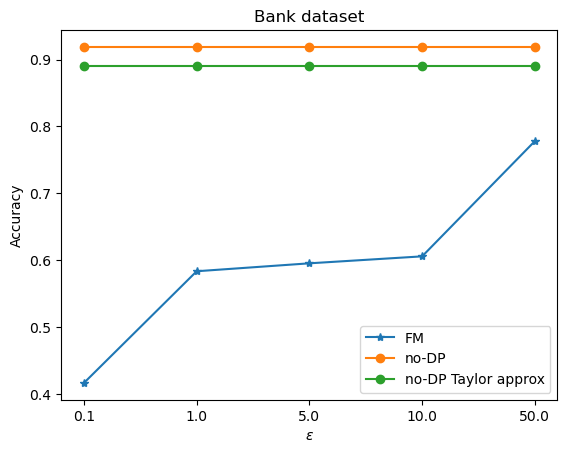

In [27]:
plt.plot(range(len(epsilon)), performance, '-*', label = 'FM')
plt.plot(range(len(epsilon)), np.ones(len(epsilon))*0.9189058339385137, '-o', label = 'no-DP')
plt.plot(range(len(epsilon)), np.ones(len(epsilon))*0.8900992495763738, '-o', label = 'no-DP Taylor approx')
plt.ylabel(r'Accuracy')
plt.xlabel(r'$\epsilon$')
plt.title('Bank dataset')
plt.xticks(range(len(epsilon)), epsilon)
plt.legend()

### 5.1 With scipy

In [28]:
# X = female_df[feature_cols].values
# y = female_df[label].values.reshape(-1, 1)

# X = X/np.linalg.norm(X, ord=2, axis=1).reshape(-1, 1)
# coff_0, coff_1, coff_2 = get_coefficient(X=X, y=y, epsilon=10.0, mode='scipy_dp')
# print(coff_1.shape, coff_2.shape)

In [29]:
# model = np.random.normal(0.0, 1.0, coff_1.shape)
# print(model.shape)

In [30]:
# def sigmoid(x):
#     return np.exp(x)/(1 + np.exp(x))

# def f(w):
#     return coff_0 + np.squeeze(np.dot(coff_1.T, w)) + np.sum(coff_2*np.dot(w, w.T))

In [31]:
# res = minimize(f, model, method='CG')
# print(res)

In [32]:
# best_model = res['x'].reshape(-1,1)
# pred = sigmoid(np.dot(X, best_model))
# print(pred.shape)

In [33]:
# acc = accuracy_score(y_true=y, y_pred=np.round(pred))
# print("Accuracy score: {}".format(acc))

In [34]:
# X = train_df[feature_cols].values
# y = train_df[label].values.reshape(-1, 1)

# X = X/np.linalg.norm(X, ord=2, axis=1).reshape(-1, 1)
# pred = pred = sigmoid(np.dot(X, best_model))
# acc = accuracy_score(y_true=y, y_pred=np.round(pred))
# print("Accuracy score: {}".format(acc))